In [1]:
import msgpack
import pandas as pd

* For each bracket...
* Find the best score at each decision point

In [2]:
import toolz
from sklearn.utils import check_random_state
import itertools

In [3]:
pd.__version__

'1.0.2'

In [4]:
# from sklearn.datasets import make_circles
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# X1, y1 = make_circles(n_samples=30_000, random_state=0, noise=0.04)
# X2, y2 = make_circles(n_samples=30_000, random_state=1, noise=0.04)
# X2[:, 0] += 0.6
# X_info = np.concatenate((X1, X2))
# y = np.concatenate((y1, y2 + 2))

# df = pd.DataFrame(X_info)
# df["y"] = y
# ax = df.plot.scatter(x=0, y=1, c="y", cmap="tab10", vmax=10, alpha=0.03)
# # ax.yaxis.set_major_locator(plt.NullLocator())
# # ax.xaxis.set_major_formatter(plt.NullFormatter())
# ax.set_ylabel("")
# plt.savefig("figs/synthetic-dataset.png", dpi=300, bbox_inches="tight")

In [5]:
today = "2019-06-22-more-aggressive"
today = "2019-07-08"

def _to_str_keys(d):
    if isinstance(d, list):
        return [_to_str_keys(di) for di in d]
    if isinstance(d, dict):
        out = {}
        for k, v in d.items():
            out[_to_str_keys(k)] = _to_str_keys(v)
        return out
    if isinstance(d, bytes):
        return d.decode()
    return d
    
with open(f"out/{today}-histories-2.msgpack", "rb") as f:
    histories = msgpack.load(f)

histories = _to_str_keys(histories)

In [6]:
def shape_history(history, **kwargs):
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "random_state": row["random_state"],
                 **kwargs}]
    return out

In [7]:
hyperband_params = [
    tuple({k: v for k, v in h["params"].items() if "hidden" not in k}.items())
    for hist in histories["hyperband"]
    for h in hist
]
passive_params = [
    tuple({k: v for k, v in h["params"].items() if "hidden" not in k}.items())
    for hist in histories["passive"]
    for h in hist
]


hyperband_params = {h for h in hyperband_params}
passive_params = {h for h in passive_params}

same = hyperband_params.intersection(passive_params)
len(same), len(hyperband_params), len(same) / len(hyperband_params)

(1000, 75600, 0.013227513227513227)

In [8]:
from sklearn.utils import check_random_state
def shape_history(history, **kwargs):
#     global hist_df
    scores = {}
    pf_calls = {}
    print(kwargs)
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    hist_df = pd.DataFrame(history)
    for _, row in hist_df.iterrows():
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "random_state": row["random_state"],
                 **kwargs}]
    return out

In [9]:
import pandas as pd

hists = [
    shape_history(hist, alg=alg, k=k)
    for alg, hists in histories.items()
    for k, hist in enumerate(hists)
]

{'alg': 'hyperband', 'k': 0}
{'alg': 'hyperband', 'k': 1}
{'alg': 'hyperband', 'k': 2}
{'alg': 'hyperband', 'k': 3}
{'alg': 'hyperband', 'k': 4}
{'alg': 'hyperband', 'k': 5}
{'alg': 'hyperband', 'k': 6}
{'alg': 'hyperband', 'k': 7}
{'alg': 'hyperband', 'k': 8}
{'alg': 'hyperband', 'k': 9}
{'alg': 'hyperband', 'k': 10}
{'alg': 'hyperband', 'k': 11}
{'alg': 'hyperband', 'k': 12}
{'alg': 'hyperband', 'k': 13}
{'alg': 'hyperband', 'k': 14}
{'alg': 'hyperband', 'k': 15}
{'alg': 'hyperband', 'k': 16}
{'alg': 'hyperband', 'k': 17}
{'alg': 'hyperband', 'k': 18}
{'alg': 'hyperband', 'k': 19}
{'alg': 'hyperband', 'k': 20}
{'alg': 'hyperband', 'k': 21}
{'alg': 'hyperband', 'k': 22}
{'alg': 'hyperband', 'k': 23}
{'alg': 'hyperband', 'k': 24}
{'alg': 'hyperband', 'k': 25}
{'alg': 'hyperband', 'k': 26}
{'alg': 'hyperband', 'k': 27}
{'alg': 'hyperband', 'k': 28}
{'alg': 'hyperband', 'k': 29}
{'alg': 'hyperband', 'k': 30}
{'alg': 'hyperband', 'k': 31}
{'alg': 'hyperband', 'k': 32}
{'alg': 'hyperband',

In [10]:
import numpy as np
array = np.array([3, 6, 9, 27])
base = 3
_exp = np.log(array) / np.log(base)
3**np.round(_exp)

array([ 3.,  9.,  9., 27.])

In [11]:
import numpy as np
def smooth(df, div=10):
    col = "cumulative_partial_fit_calls"
#     base = 3 / 2
#     exponent = np.log(df[col]) / np.log(base)
#     exponent = np.round(exponent)
#     df[col] = base**exponent
    df[col] = (df[col] // div) * div
    # df[col] = np.round(df[col], decimals=-2)
    return df

raw_dfs = [pd.DataFrame(hist) for hist in hists]
print(raw_dfs[-1].cumulative_partial_fit_calls.unique()[:5])
print(sum(len(df) for df in raw_dfs))
dfs = [smooth(df, div=6 * 10) for df in raw_dfs]
print(sum(len(df) for df in raw_dfs))
df = pd.concat(dfs)
df.cumulative_partial_fit_calls.unique()[:5]

[1 2 3 4 5]
247800
247800


array([  0,  60, 120, 180, 300])

In [12]:
show = [df for df in raw_dfs 
        if df.loc[0, "alg"] == "hyperband"
        and df.loc[0, "random_state"] == 403]
show = show[0]

# show.plot(x="cumulative_partial_fit_calls", y="best_score")

In [13]:
df.random_state.unique()

array([400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412,
       413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425,
       426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438,
       439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451,
       500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512,
       513, 514, 515, 516, 517, 518, 519, 600, 601, 602, 603, 604, 605,
       606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618,
       619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631,
       632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644,
       645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657,
       658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670,
       671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683,
       684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696,
       697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 70

In [14]:
import seaborn as sns

df["epochs"] = df["cumulative_partial_fit_calls"] / 6

kwargs = dict(
    index="epochs",
    values="best_score",
    columns="alg",
)

middle = df.pivot_table(aggfunc="mean", **kwargs)
lower = df.pivot_table(aggfunc=lambda x: x.quantile(q=0.25), **kwargs)
upper = df.pivot_table(aggfunc=lambda x: x.quantile(q=0.75), **kwargs)

In [15]:
df.to_csv("all-runs.csv", index=False)

In [16]:
# middle.describe()

passive
hyperband


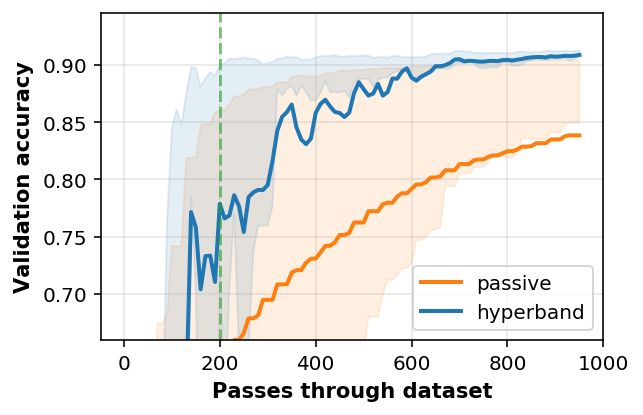

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

w = 3
fig, ax = plt.subplots(figsize=(1.5 * w, w))

colors = {"hyperband": "C0", "passive": "C1"}
for alg in ["passive", "hyperband"]:
    print(alg)
    show_mid = middle[alg].dropna()
    show_low = lower[alg].dropna()
    show_upp = upper[alg].dropna()
    
    show_mid.plot(ax=ax, color=colors[alg], linewidth=2)
#     show_low.plot(ax=ax, color=colors[alg], style="--")
    col = "epochs"
    ax.fill_between(show_low.index, show_low.values, show_upp.values, alpha=0.12, color=colors[alg])
ax.set_ylim(0.66, None)
ax.set_xlim(None, 1000)
ax.legend(loc="lower right")
ax.grid(linestyle="-", alpha=0.3)

fontdict = {"weight": "bold", "fontsize": 10.5}
ax.set_ylabel("Validation accuracy", fontdict=fontdict)
ax.set_xlabel("Passes through dataset", fontdict=fontdict)
line = np.ones(2) * 50 * 4
ax.plot(line, ax.get_ylim(), "C2--", alpha=0.6)
# plt.savefig("figs/synthetic-val-acc.pdf", bbox_inches="tight")

passive
hyperband


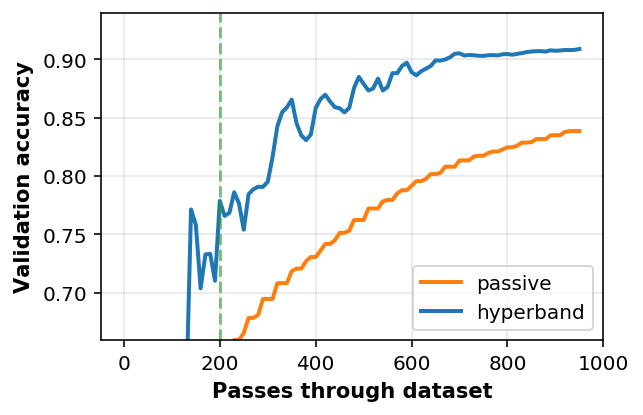

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

w = 3
fig, ax = plt.subplots(figsize=(1.5 * w, w))

colors = {"hyperband": "C0", "passive": "C1"}
for alg in ["passive", "hyperband"]:
    print(alg)
    show_mid = middle[alg].dropna()
    show_low = lower[alg].dropna()
    show_upp = upper[alg].dropna()
    
    show_mid.plot(ax=ax, color=colors[alg], linewidth=2)
#     show_low.plot(ax=ax, color=colors[alg], style="--")
    col = "epochs"
#     ax.fill_between(show_low.index, show_low.values, show_upp.values, alpha=0.12, color=colors[alg])
ax.set_ylim(0.66, None)
ax.set_xlim(None, 1000)
ax.legend(loc="lower right")
ax.grid(linestyle="-", alpha=0.3)

fontdict = {"weight": "bold", "fontsize": 10.5}
ax.set_ylabel("Validation accuracy", fontdict=fontdict)
ax.set_xlabel("Passes through dataset", fontdict=fontdict)
line = np.ones(2) * 50 * 4
ax.plot(line, ax.get_ylim(), "C2--", alpha=0.6)
plt.savefig("figs/synthetic-val-acc-prelim.pdf", bbox_inches="tight")

In [19]:
import pandas as pd
today = "2019-07-08"
fontdict = {"weight": "bold", "fontsize": 10.5}
scores = pd.read_csv(f"out/{today}-best-scores.csv")
scores.columns

Index(['activation', 'alg', 'alpha', 'batch_size', 'hidden_layer_sizes',
       'learning_rate', 'learning_rate_init', 'momentum', 'n_iter_no_change',
       'nesterovs_momentum', 'power_t', 'random_state', 'score', 'solver'],
      dtype='object')

99


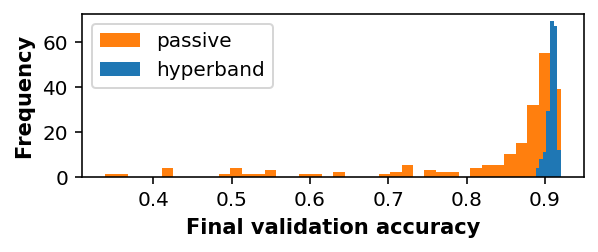

In [20]:
import matplotlib.pyplot as plt

w = 1.5
fig, ax = plt.subplots(figsize=(3 * w, w))

bins = {"hyperband": 7, "passive": 40}

colors = {"hyperband": "C0", "passive": "C1"}
for alg in ["passive", "hyperband"]:
    show = scores[scores.alg == alg]
    alpha = 1.00 if alg == "hyperband" else 1
#     alpha = 1.0
    show.score.plot.hist(ax=ax, label=alg, bins=bins[alg],
                         color=colors[alg], alpha=alpha)
# ax.set_ylim(None, 30)
ax.legend(loc="best")
ax.set_xlabel("Final validation accuracy", fontdict=fontdict)
ax.set_ylabel("Frequency", fontdict=fontdict)

passive = scores[scores.alg == "passive"]
i = passive.score <= 0.70
assert len(passive) == len(i)
hyperband = scores[scores.alg == "hyperband"].score
passive = scores[scores.alg == "passive"].score
j = passive < hyperband.min()
print(j.sum())

plt.savefig("figs/synthetic-final-acc.pdf", bbox_inches="tight")

In [21]:
params = pd.read_csv(f"out/{today}-best-params.csv")

params[params.alg == "hyperband"]

,activation,alg,alpha,batch_size,best_score_,hidden_layer_sizes,learning_rate,learning_rate_init,momentum,n_iter_no_change,nesterovs_momentum,power_t,random_state,solver
0,relu,hyperband,0.000130,64,0.906190,"(12, 12)",constant,0.005831,0.847848,inf,True,0.118418,1920,sgd
1,relu,hyperband,0.000484,32,0.911108,"(12, 12)",constant,0.006135,0.265265,inf,True,0.310611,2786,sgd
2,relu,hyperband,0.000141,64,0.912068,"(12, 12)",constant,0.005367,0.837838,inf,True,0.396296,3058,sgd
3,relu,hyperband,0.000008,32,0.910389,"(12, 12)",constant,0.000818,0.949950,inf,True,0.210511,5633,sgd
4,relu,hyperband,0.000973,64,0.912548,"(12, 12)",constant,0.004717,0.295295,inf,True,0.117618,2893,sgd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,relu,hyperband,0.000220,32,0.911348,"(12, 12)",constant,0.001211,0.783784,inf,True,0.453954,4265,sgd
196,relu,hyperband,0.000013,32,0.912068,"(12, 12)",constant,0.000948,0.922923,inf,True,0.436336,5673,sgd
197,relu,hyperband,0.000011,64,0.908229,"(6, 6, 6, 6)",constant,0.003203,0.855856,inf,True,0.758258,4054,sgd
198,relu,hyperband,0.000001,128,0.910988,"(12, 12)",constant,0.006635,0.784785,inf,True,0.674174,4235,sgd
